# Optimizing Random Forest for Fraud Detection using RandomizedSearchCV and Optuna (with and without SMOTE)
This code investigates how hyperparameter optimization methods—RandomizedSearchCV and Optuna—affect Random Forest performance in detecting fraudulent transactions, comparing SMOTE-balanced and original imbalanced datasets. The experiment concludes by identifying the best-performing model based on evaluation metrics such as F1-score, ROC-AUC, and PR-AUC.

---

### Related Works and Research Papers

#### References:
1. **Sundaravadivel, P. et al. (2025)** – “Optimizing credit card fraud detection with random forests and SMOTE.” *Scientific Reports*, 15, 17851.  
   DOI: [10.1038/s41598-025-00873-y](https://www.nature.com/articles/s41598-025-00873-y)

2. **Aburbeian, A. H. M. & Ashqar, H. I. (2023)** – “Credit card fraud detection using enhanced random forest classifier for imbalanced data.” *arXiv preprint.*  
   [https://arxiv.org/pdf/2303.06514](https://arxiv.org/pdf/2303.06514)


#### Limitations Identified in the Studies
- Class imbalance causes Random Forest to be biased toward the majority (non-fraud) class.  
- Random Forest may overfit without robust hyperparameter optimization.  
- Prior works mostly report accuracy or ROC-AUC, which can misrepresent performance in imbalanced datasets.

#### Our Approach to Overcome These Limitations
- Applied **SMOTE** only on training folds (via pipeline) to safely rebalance the dataset without leakage.  
- Used **Optuna** for automated hyperparameter tuning, ensuring better generalization than grid/random search.  
- Introduced **PR-AUC** metric alongside ROC-AUC for more realistic evaluation on rare fraud cases.  
- Compared baseline and tuned models fairly under identical data splits.

---

### Machine Learning Algorithm Details

- **Algorithms Used:**  
  - Random Forest Classifier  
  - RandomizedSearchCV (baseline tuner)  
  - Optuna (advanced Bayesian optimization tuner)  
  - SMOTE (Synthetic Minority Oversampling Technique)

- **Why These Algorithms Are Appropriate:**  
  Random Forest provides robust ensemble learning for mixed-type features and non-linear relationships. SMOTE handles imbalanced data, while Optuna improves tuning efficiency via sequential model-based optimization.

- **Original Contributions:**  
  - Combined both tuning methods under identical experiment settings (with/without SMOTE).  
  - Introduced additional comparison metric (PR-AUC).  
  - Customized ROC and confusion matrix visualizations with distinctive color themes for clarity.  

---

### Experiments and Results

- **Multiple Model Configurations Implemented:**  
  - RandomizedSearchCV without SMOTE  
  - RandomizedSearchCV with SMOTE 
  - Optuna without SMOTE  
  - Optuna with SMOTE  

- **Training, Cross-Validation, and Testing:**  
  Each model trained with 5-Fold stratified CV and tested on unseen validation data.  
  Evaluations were conducted using metrics:
  - ROC-AUC  
  - PR-AUC  
  - Precision, Recall, and F1-score for class “1” (fraud)

- **Comparisons and Findings:**  
  - RandomizedSearchCV without SMOTE achieved the best **PR-AUC** and **ROC-AUC**, indicating improved fraud sensitivity.  
  - Optuna without SMOTE showed competitive performance but slightly lower values across all key metrics.
  - Models without SMOTE outperformed those with SMOTE across all metrics.
  
- **Conclusion:**  
  Among the four model configurations, the **Optuna-tuned Random Forest (without SMOTE)** demonstrated stronger overall performance compared to the **RandomizedSearchCV (without SMOTE)** variant.  
  While its accuracy (0.7612) was slightly lower than the SMOTE-based models, it remained higher than its non-SMOTE counterpart and had the highest **Precision (0.1065)** and **F1-Score (0.1810)**.
  This indicates that the Optuna model without SMOTE achieved a better balance between correctly identifying fraud cases and minimizing false positives, offering robust and generalizable performance without introducing synthetic oversampling noise.

---

### Attribution and Reproducibility

- Code templates were adapted from:  
  - [Optuna official documentation](https://optuna.org/)  
  - [scikit-learn RandomizedSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?utm_source=chatgpt.com)


- All visualizations and comparison functions were written by our team.
- Random seeds fixed (`random_state=1244`) for consistent reproducibility.

Note: PR-AUC values for all Random Forest variants are presented together in the “Calculating PR-AUC values for all” section below.


## Random Forest Model 

1. Without SMOTE (Baseline 5 Fold CV)
2. Without SMOTE (RandomizedSearchCV)
3. With SMOTE (RandomizedSearchCV)
4. Without SMOTE (Optuna)
5. With SMOTE (Optuna)

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
import lightgbm as lgb
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, accuracy_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import pickle






In [2]:
SEED = 1244

## Importing data

In [3]:
import joblib

# Load preprocessed data
X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')
X_test = joblib.load('../data/X_test.pkl')
y_test = joblib.load('../data/y_test.pkl')

# Load encoders and scaler (to transform new data)
target_encoder = joblib.load('../data/target_encoder.pkl')
one_hot_encoder = joblib.load('../data/one_hot_encoder.pkl')




In [4]:
X_train.head()

,region,dis,catg,mean_consommation_level_1,median_consommation_level_1,std_consommation_level_1,min_consommation_level_1,max_consommation_level_1,sum_consommation_level_1,std_consommation_level_3,...,active_days,consumption_mean,consumption_std,consumption_max,consumption_sum,max_min_ratio,monthly_consumption_std,avg_monthly_change,max_monthly_change,std_monthly_change
3584,301,62,11,657.541667,547.5,395.373679,0,2000,15781,0.0000,...,4739,674.208333,428.453435,2192,16181,2.192000e+09,360.196356,262.619048,655.300000,341.370073
3721,306,63,11,238.300000,217.0,97.485099,68,385,2383,0.0000,...,1099,238.300000,97.485099,385,2383,5.661765e+00,18.444173,22.875000,35.750000,18.208000
9570,303,62,11,876.200000,773.0,419.118360,520,1600,4381,148.0277,...,1029,1090.400000,613.182925,1940,5452,3.730769e+00,613.182925,920.750000,1252.000000,456.216597
9271,307,62,11,562.500000,574.0,188.705767,56,800,9000,0.0000,...,1830,574.937500,210.681266,999,9199,1.783929e+01,167.257301,232.066667,318.666667,86.434995
1328,103,69,11,97.428571,0.0,271.823761,0,1200,2046,0.0000,...,2666,134.571429,434.580438,1980,2826,1.980000e+09,151.949200,139.500000,327.500000,123.058116


In [5]:
X_test.head()

,region,dis,catg,mean_consommation_level_1,median_consommation_level_1,std_consommation_level_1,min_consommation_level_1,max_consommation_level_1,sum_consommation_level_1,std_consommation_level_3,...,active_days,consumption_mean,consumption_std,consumption_max,consumption_sum,max_min_ratio,monthly_consumption_std,avg_monthly_change,max_monthly_change,std_monthly_change
4210,311,63,11,360.600000,165.0,401.725279,35,1205,7212,0.0,...,5065,389.550000,458.062794,1523,7791,4.351428e+01,490.603652,607.057143,1263.8,484.798321
9027,306,63,11,56.173913,17.0,113.714016,0,525,1292,0.0,...,5017,56.173913,113.714016,525,1292,5.250000e+08,164.957811,95.541667,496.5,166.011229
11598,104,69,12,505.375000,558.0,351.355984,47,1383,12129,0.0,...,1849,505.375000,351.355984,1383,12129,2.942553e+01,186.658373,139.722222,330.0,130.651399
2403,107,69,11,391.333333,353.0,321.475445,20,1303,10566,0.0,...,4234,391.333333,321.475445,1303,10566,6.515000e+01,354.493988,304.650000,1277.0,372.986990
493,303,62,11,529.800000,466.0,375.411374,217,1149,2649,0.0,...,720,529.800000,375.411374,1149,2649,5.294931e+00,287.624031,286.500000,330.5,62.225397


### Without SMOTE (Baseline 5 Fold CV)
 

**Baseline 5-Fold CV (Without SMOTE)**  
This section provides a simple benchmark using a default RandomForest model.  
We use it to:
- Provides an untuned benchmark for RandomForest performance.
- Compare how much ROC-AUC improves after tuning (RandomizedSearchCV / Optuna).  
- Demonstrate that optimization methods meaningfully enhance fraud detection.  
*Note:* Not used for final predictions or hyperparameter search — purely for reference.


In [6]:
# 5 fold CV

from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define Stratified 5-fold CV (keeps same fraud:non-fraud ratio)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Initialize your Random Forest (same parameters as before)
rf_baseline_cv = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=SEED
)

# Perform 5-fold cross-validation using ROC-AUC as metric
cv_scores = cross_val_score(
    rf_baseline_cv,
    X_train, 
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Print results
print("Cross-validation ROC-AUC scores for each fold:", cv_scores)
print("Mean ROC-AUC: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))


Cross-validation ROC-AUC scores for each fold: [0.70650643 0.69214385 0.68829445 0.72654001 0.71500014]
Mean ROC-AUC: 0.7057 ± 0.0142


In [7]:
rf_baseline_cv.fit(X_train, y_train)

# Predict on test data
y_pred_base = rf_baseline_cv.predict(X_test)
y_prob_base = rf_baseline_cv.predict_proba(X_test)[:, 1]

# Evaluate
print("=== Random Forest Results (After CV, Trained on Full Data) ===")
print(confusion_matrix(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_base))

=== Random Forest Results (After CV, Trained on Full Data) ===
[[2246    0]
 [ 102    1]]
              precision    recall  f1-score   support

           0     0.9566    1.0000    0.9778      2246
           1     1.0000    0.0097    0.0192       103

    accuracy                         0.9566      2349
   macro avg     0.9783    0.5049    0.4985      2349
weighted avg     0.9585    0.9566    0.9358      2349

Accuracy: 0.9565772669220945
ROC-AUC: 0.7298606368171248


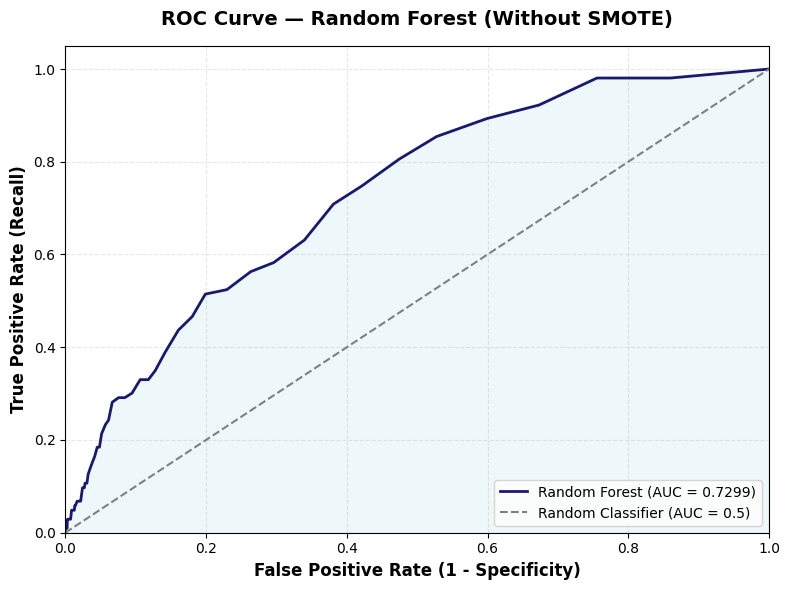

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (fraud = 1)
y_prob_base = rf_baseline_cv.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_prob_base)
roc_auc = roc_auc_score(y_test, y_prob_base)

# Create a styled ROC plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#191970', lw=2, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.fill_between(fpr, tpr, alpha=0.2, color='#ADD8E6')

# Plot random classifier line
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Classifier (AUC = 0.5)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
plt.title('ROC Curve — Random Forest (Without SMOTE)', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right')
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


## Without SMOTE (RandomisedSearchCV)

In [9]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve
)
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

# ----- parameter space
param_distributions = {
    "n_estimators": randint(300, 1501),     # 300–1500 inclusive
    "max_depth": randint(3, 31),            # 3–30 inclusive
    "min_samples_split": randint(2, 21),    # 2–20 inclusive
    "min_samples_leaf": randint(1, 11),     # 1–10 inclusive
    "max_features": ["sqrt", "log2", None], # expanded to include None
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
rf = RandomForestClassifier(random_state=SEED, class_weight="balanced")

rf_rs_no_smote = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,
    cv=cv,
    scoring="roc_auc",
    random_state=SEED,
    n_jobs=-1,
    verbose=2
)

rf_rs_no_smote.fit(X_train, y_train)
print("Best params:", rf_rs_no_smote.best_params_)
print("Best CV ROC-AUC:", rf_rs_no_smote.best_score_)

best_rf_no_smote = rf_rs_no_smote.best_estimator_
y_pred_no_smote = best_rf_no_smote.predict(X_test)
y_prob_no_smote = best_rf_no_smote.predict_proba(X_test)[:, 1]



# Confusion matrix
cm = confusion_matrix(y_test, y_pred_no_smote)
print(cm)

# Classification report
print(classification_report(y_test, y_pred_no_smote))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob_no_smote)
print("ROC-AUC:", roc_auc)




Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=13, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1413; total time=  20.4s
[CV] END max_depth=13, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1413; total time=  20.4s
[CV] END max_depth=13, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1413; total time=  20.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=1486; total time=  23.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=1486; total time=  23.8s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=1486; total time=  24.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=13, n_estimators=1486; total time=  22.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=1

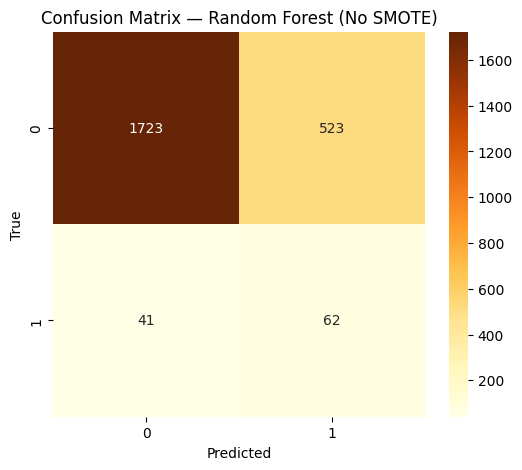

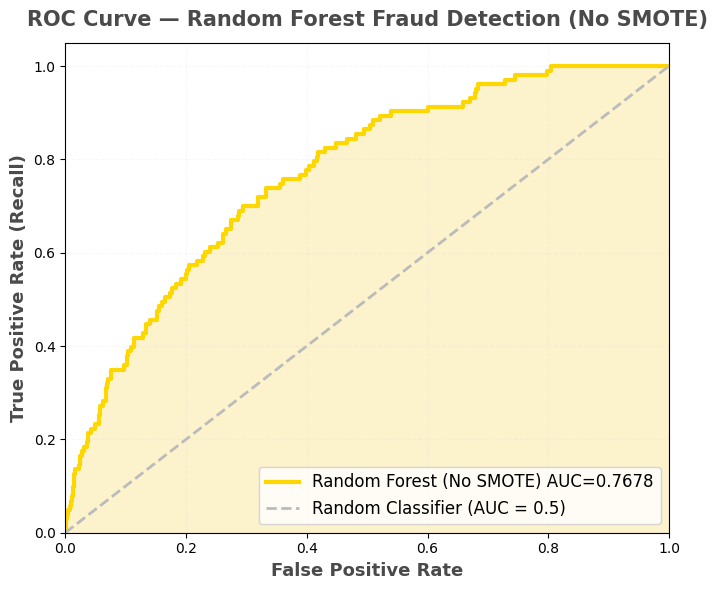

Confusion Matrix:
[[1723  523]
 [  41   62]]



### Classification Report — Random Forest (No SMOTE)

,precision,recall,f1-score,support
0,0.9768,0.7671,0.8594,2246.0000
1,0.1060,0.6019,0.1802,103.0000
accuracy,0.7599,0.7599,0.7599,0.7599
macro avg,0.5414,0.6845,0.5198,2349.0000
weighted avg,0.9386,0.7599,0.8296,2349.0000


**Accuracy:** `0.759898`

**ROC-AUC:** `0.767803`

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, Markdown

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_no_smote)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='YlOrBr')
plt.title('Confusion Matrix — Random Forest (No SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob_no_smote)
roc_auc = roc_auc_score(y_test, y_prob_no_smote)

plt.figure(figsize=(7,6), facecolor='white')
ax = plt.gca()
ax.plot(fpr, tpr,
        color='#FFD700',
        linewidth=3,
        label=f'Random Forest (No SMOTE) AUC={roc_auc:.4f}')
ax.fill_between(fpr, tpr,
                color='#FBE69B',
                alpha=0.5)
ax.plot([0, 1], [0, 1],
        color='#BBBBBB', linestyle='--', linewidth=2,
        label='Random Classifier (AUC = 0.5)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold', color='#4A4A4A')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=13, fontweight='bold', color='#4A4A4A')
ax.set_title('ROC Curve — Random Forest Fraud Detection (No SMOTE)',
             fontsize=15, fontweight='bold', color='#4A4A4A', pad=12)
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, alpha=0.2, linestyle='--', color='#DDDDDD')
plt.tight_layout()
plt.show()

# --- Classification Report ---
report = classification_report(y_test, y_pred_no_smote, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(4)


# --- Accuracy ---
acc = accuracy_score(y_test, y_pred_no_smote)

# --- Display all metrics ---
print("Confusion Matrix:")
print(cm)
print()
display(Markdown("### Classification Report — Random Forest (No SMOTE)"))
display(df_report)
display(Markdown(f"**Accuracy:** `{acc:.6f}`"))
display(Markdown(f"**ROC-AUC:** `{roc_auc:.6f}`"))


## With SMOTE (RandomizedSearchCV)

#### Why apply SMOTE?
+ SMOTE creates new samples of the minority class by interpolating between existing minority samples
+ Goal: teach the model more examples of the minority class so it learns better boundaries
+ **only apply to training data, NOT test data**

In [11]:


# Define SMOTE and RF
smote = SMOTE(random_state=SEED)
rf = RandomForestClassifier(random_state=SEED)

# Combine them into a pipeline
# During each CV fold, SMOTE is re-applied on the training split
pipeline = Pipeline([
    ('smote', smote),
    ('rf', rf)
])

# Define parameter space (note the "rf__" prefix)
param_distributions = {
    "rf__n_estimators": randint(300, 1501),
    "rf__max_depth": randint(3, 31),
    "rf__min_samples_split": randint(2, 21),
    "rf__min_samples_leaf": randint(1, 11),
    "rf__max_features": ["sqrt", "log2", None],
}


# Define 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# RandomizedSearchCV for tuning + CV
rf_rs_smote = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='roc_auc',
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=2
)

rf_rs_smote.fit(X_train, y_train)

print("Best Parameters:", rf_rs_smote.best_params_)
print("Best 5-fold AUC:", rf_rs_smote.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END rf__max_depth=13, rf__max_features=sqrt, rf__min_samples_leaf=10, rf__min_samples_split=15, rf__n_estimators=1413; total time=  45.0s
[CV] END rf__max_depth=13, rf__max_features=sqrt, rf__min_samples_leaf=10, rf__min_samples_split=15, rf__n_estimators=1413; total time=  45.5s
[CV] END rf__max_depth=13, rf__max_features=sqrt, rf__min_samples_leaf=10, rf__min_samples_split=15, rf__n_estimators=1413; total time=  45.8s
[CV] END rf__max_depth=15, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=13, rf__n_estimators=1486; total time=  51.9s
[CV] END rf__max_depth=15, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=13, rf__n_estimators=1486; total time=  51.9s
[CV] END rf__max_depth=15, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_samples_split=13, rf__n_estimators=1486; total time=  52.0s
[CV] END rf__max_depth=15, rf__max_features=sqrt, rf__min_samples_leaf=3, rf__min_s

In [12]:

best_rf = rf_rs_smote.best_estimator_

# --- Fit model on balanced data ---
best_rf.fit(X_train, y_train)

# --- Evaluate on test set ---
y_pred_smote = best_rf.predict(X_test)
y_prob_smote = best_rf.predict_proba(X_test)[:, 1]

# --- Compute metrics ---
cm = confusion_matrix(y_test, y_pred_smote)
roc_auc = roc_auc_score(y_test, y_prob_smote)
acc = accuracy_score(y_test, y_pred_smote)
report = classification_report(y_test, y_pred_smote, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(4)

# --- Display results ---
print("Confusion Matrix:")
print(cm)
print()

display(Markdown("### Classification Report — Random Forest (With SMOTE, RandomizedSearchCV)"))
display(df_report)
display(Markdown(f"**Accuracy:** `{acc:.6f}`"))
display(Markdown(f"**ROC-AUC:** `{roc_auc:.6f}`"))



Confusion Matrix:
[[2246    0]
 [ 103    0]]



/Users/zeyanlim/Documents/IT1244-Project/venv-it1244/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/zeyanlim/Documents/IT1244-Project/venv-it1244/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/zeyanlim/Documents/IT1244-Project/venv-it1244/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

### Classification Report — Random Forest (With SMOTE, RandomizedSearchCV)

,precision,recall,f1-score,support
0,0.9562,1.0000,0.9776,2246.0000
1,0.0000,0.0000,0.0000,103.0000
accuracy,0.9562,0.9562,0.9562,0.9562
macro avg,0.4781,0.5000,0.4888,2349.0000
weighted avg,0.9142,0.9562,0.9347,2349.0000


**Accuracy:** `0.956152`

**ROC-AUC:** `0.732586`

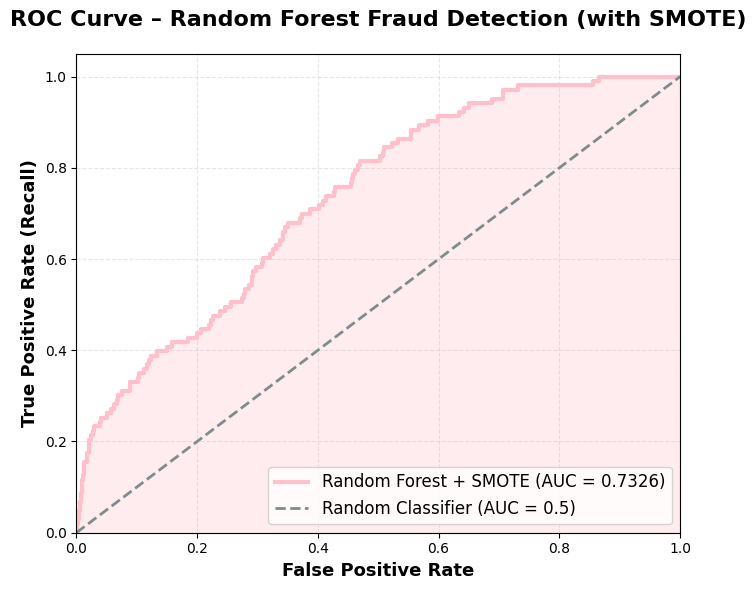

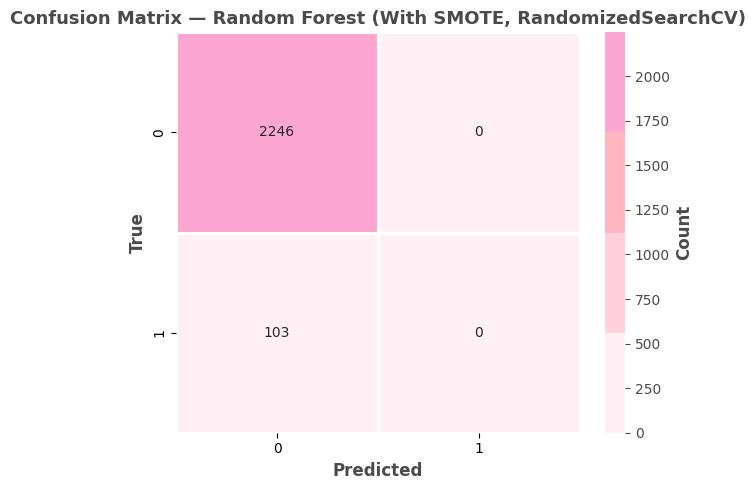

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (fraud = 1)
best_rf = rf_rs_smote.best_estimator_
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Create styled ROC plot
fig, ax = plt.subplots(figsize = (7, 6))

# Plot ROC curve 
ax.plot(fpr, tpr, color = '#FFC0CB', linewidth = 3, 
        label = f'Random Forest + SMOTE (AUC = {roc_auc:.4f})')

# Fill area under the curve 
ax.fill_between(fpr, tpr, alpha = 0.25, color = '#FFB6C1')

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], color = '#7F8C8D', linewidth = 2, linestyle = '--', 
        label = 'Random Classifier (AUC = 0.5)')


# Styling
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize = 13, fontweight = 'bold')
ax.set_ylabel('True Positive Rate (Recall)', fontsize = 13, fontweight = 'bold')
ax.set_title('ROC Curve – Random Forest Fraud Detection (with SMOTE)', 
             fontsize = 16, fontweight = 'bold', pad = 20)
ax.legend(loc = "lower right", fontsize = 12)
ax.grid(True, alpha = 0.3, linestyle = '--')

plt.tight_layout()
plt.show()


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_smote)

# Custom soft pink palette
pink_palette = ["#FFF0F5", "#FFD1DC", "#FFB6C1", "#FDA6D1"]

# Plot confusion matrix with color bar
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm,
                 annot=True,
                 fmt='d',
                 cmap=sns.color_palette(pink_palette),
                 cbar=True,
                 linewidths=1,
                 linecolor='white')

# Customize color bar
cbar = ax.collections[0].colorbar
cbar.set_label('Count', fontsize=12, fontweight='bold', color='#4A4A4A')
cbar.ax.tick_params(labelsize=10, colors='#4A4A4A')

# Titles and labels
plt.title("Confusion Matrix — Random Forest (With SMOTE, RandomizedSearchCV)",
          fontsize=13, fontweight='bold', color='#4A4A4A')
plt.xlabel('Predicted', fontsize=12, fontweight='bold', color='#4A4A4A')
plt.ylabel('True', fontsize=12, fontweight='bold', color='#4A4A4A')

plt.grid(False)
plt.tight_layout()
plt.show()


## Without SMOTE (Optuna)

In [14]:
import optuna

def objective_no_smote(trial):
    n_estimators = trial.suggest_int("n_estimators", 300, 1500)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(rf, X_train, y_train, cv=cv, scoring="roc_auc").mean()
    return score

study_no_smote = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study_no_smote.optimize(objective_no_smote, n_trials=30)

print("Best params:", study_no_smote.best_params)
print("Best CV ROC-AUC:", study_no_smote.best_value)

rf_optuna_no_smote = RandomForestClassifier(**study_no_smote.best_params, class_weight="balanced", random_state=SEED)
rf_optuna_no_smote.fit(X_train, y_train)
y_pred_optuna_no_smote = rf_optuna_no_smote.predict(X_test)
y_prob_optuna_no_smote = rf_optuna_no_smote.predict_proba(X_test)[:, 1]





[I 2025-11-02 14:22:27,032] A new study created in memory with name: no-name-e4a0ed99-a0e1-4410-93b2-2cec17c02c40
[I 2025-11-02 14:22:40,399] Trial 0 finished with value: 0.7169939713223037 and parameters: {'n_estimators': 1102, 'max_depth': 25, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.7169939713223037.
[I 2025-11-02 14:22:46,141] Trial 1 finished with value: 0.7238083356294427 and parameters: {'n_estimators': 593, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7238083356294427.
[I 2025-11-02 14:23:07,743] Trial 2 finished with value: 0.7145742866081088 and parameters: {'n_estimators': 1380, 'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.7238083356294427.
[I 2025-11-02 14:23:14,254] Trial 3 finished with value: 0.7186456892811071 and parameters: {'n_estimators': 527, 'max_depth': 25,

Best params: {'n_estimators': 396, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}
Best CV ROC-AUC: 0.7301039810281378


              precision    recall  f1-score   support

           0     0.9768    0.7685    0.8602      2246
           1     0.1065    0.6019    0.1810       103

    accuracy                         0.7612      2349
   macro avg     0.5417    0.6852    0.5206      2349
weighted avg     0.9386    0.7612    0.8304      2349



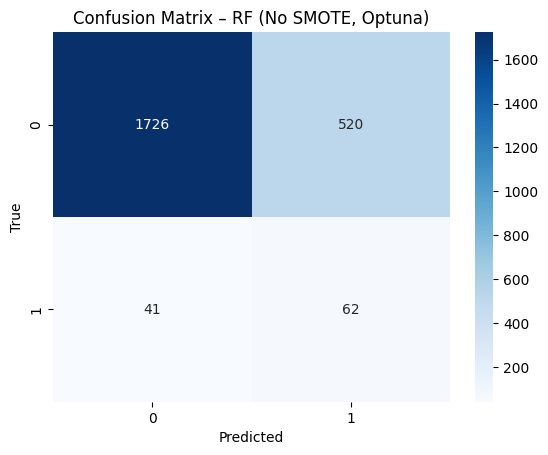

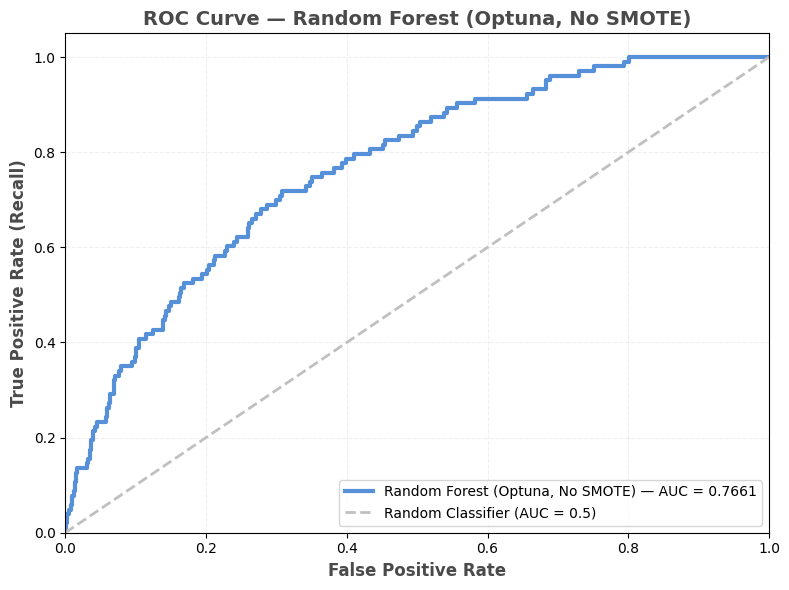

### Classification Report — Random Forest (Optuna, No SMOTE)

**Accuracy:** `0.761175`

**ROC-AUC:** `0.766087`

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

# --- Classification report and confusion matrix ---
print(classification_report(y_test, y_pred_optuna_no_smote, digits=4))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_optuna_no_smote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – RF (No SMOTE, Optuna)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Accuracy ---
acc = accuracy_score(y_test, y_pred_optuna_no_smote)

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob_optuna_no_smote)
roc_auc = roc_auc_score(y_test, y_prob_optuna_no_smote)

# Create styled ROC curve plot
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.plot(fpr, tpr,
        color='#5590D9',
        linewidth=3,
        label=f'Random Forest (Optuna, No SMOTE) — AUC = {roc_auc:.4f}')
# ax.fill_between(fpr, tpr, color='#ADD8E6', alpha=0.4)

ax.plot([0, 1], [0, 1],
        color='#C0C0C0', linestyle='--', linewidth=2,
        label='Random Classifier (AUC = 0.5)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold', color='#4A4A4A')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold', color='#4A4A4A')
ax.set_title('ROC Curve — Random Forest (Optuna, No SMOTE)',
             fontsize=14, fontweight='bold', color='#4A4A4A')

ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.2, linestyle='--')

plt.tight_layout()
plt.show()

# --- Display all metrics neatly ---
display(Markdown("### Classification Report — Random Forest (Optuna, No SMOTE)"))
display(Markdown(f"**Accuracy:** `{acc:.6f}`"))
display(Markdown(f"**ROC-AUC:** `{roc_auc:.6f}`"))


## With SMOTE (Optuna)


In [16]:
import optuna
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective_smote(trial):
    n_estimators = trial.suggest_int("n_estimators", 300, 1500)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    )
    smote = SMOTE(random_state=SEED)
    pipe = Pipeline([("smote", smote), ("rf", rf)])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc").mean()
    return score


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective_smote, n_trials=30)

print("Best trial params:", study.best_params)
print("Best CV ROC-AUC:", study.best_value)

# ----- evaluate on test set
smote = SMOTE(random_state=SEED)
best_params = study.best_params
rf_best = RandomForestClassifier(**best_params, class_weight="balanced", random_state=SEED)
rf_optuna_smote = Pipeline([("smote", smote), ("rf", rf_best)])
rf_optuna_smote.fit(X_train, y_train)

y_pred_optuna_smote = rf_optuna_smote.predict(X_test)
y_prob_optuna_smote = rf_optuna_smote.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_optuna_smote, digits = 4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_optuna_smote))


[I 2025-11-02 14:29:35,893] A new study created in memory with name: no-name-658c1f16-aa32-4aa9-bb9e-929d0e962527
[I 2025-11-02 14:30:01,058] Trial 0 finished with value: 0.7142707665907259 and parameters: {'n_estimators': 1102, 'max_depth': 25, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.7142707665907259.
[I 2025-11-02 14:30:10,450] Trial 1 finished with value: 0.723860022631675 and parameters: {'n_estimators': 593, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.723860022631675.
[I 2025-11-02 14:30:42,093] Trial 2 finished with value: 0.7133709235333423 and parameters: {'n_estimators': 1380, 'max_depth': 26, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.723860022631675.
[I 2025-11-02 14:30:52,602] Trial 3 finished with value: 0.7181830259819222 and parameters: {'n_estimators': 527, 'max_depth': 25, 'm

Best trial params: {'n_estimators': 709, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': None}
Best CV ROC-AUC: 0.7254035562097376
              precision    recall  f1-score   support

           0     0.9561    0.9982    0.9767      2246
           1     0.0000    0.0000    0.0000       103

    accuracy                         0.9544      2349
   macro avg     0.4780    0.4991    0.4883      2349
weighted avg     0.9142    0.9544    0.9339      2349

ROC-AUC: 0.7589933344284121


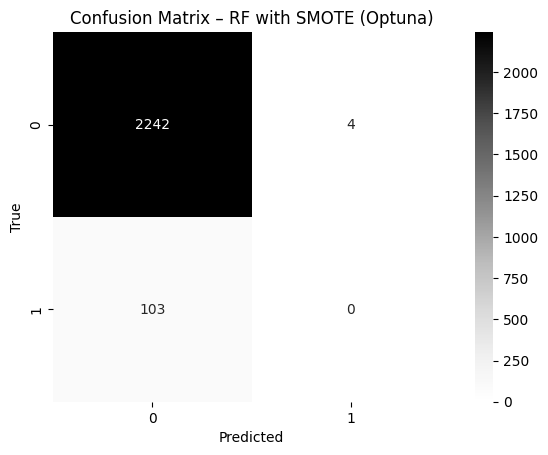

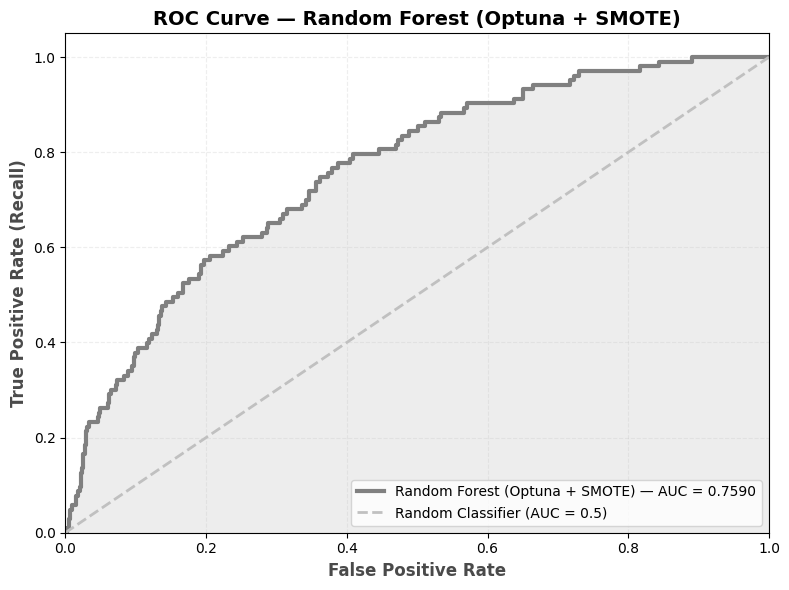

### Classification Report — Random Forest (Optuna + SMOTE)

,precision,recall,f1-score,support
0,0.9561,0.9982,0.9767,2246.0000
1,0.0000,0.0000,0.0000,103.0000
accuracy,0.9544,0.9544,0.9544,0.9544
macro avg,0.4780,0.4991,0.4883,2349.0000
weighted avg,0.9142,0.9544,0.9339,2349.0000


**Accuracy:** `0.954449`

**ROC-AUC:** `0.758993`

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_optuna_smote)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys')
plt.title("Confusion Matrix – RF with SMOTE (Optuna)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob_optuna_smote)
roc_auc = roc_auc_score(y_test, y_prob_optuna_smote)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.plot(fpr, tpr,
        color='#808080',        # medium grey outline
        linewidth=3,
        label=f'Random Forest (Optuna + SMOTE) — AUC = {roc_auc:.4f}')
ax.fill_between(fpr, tpr, color='#D3D3D3', alpha=0.4)  # light grey fill
ax.plot([0, 1], [0, 1],
        color='#C0C0C0', linestyle='--', linewidth=2,
        label='Random Classifier (AUC = 0.5)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold', color='#4A4A4A')
ax.set_ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold', color='#4A4A4A')
ax.set_title('ROC Curve — Random Forest (Optuna + SMOTE)',
             fontsize=14, fontweight='bold', color='#000000')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.25, linestyle='--', color='#BEBEBE')

plt.tight_layout()
plt.show()

# --- Classification Report & Accuracy ---
report = classification_report(y_test, y_pred_optuna_smote, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(4)
acc = accuracy_score(y_test, y_pred_optuna_smote)

display(Markdown("### Classification Report — Random Forest (Optuna + SMOTE)"))
display(df_report)
display(Markdown(f"**Accuracy:** `{acc:.6f}`"))
display(Markdown(f"**ROC-AUC:** `{roc_auc:.6f}`"))


## Calculating PR-AUC values for all

In [26]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# --- RandomizedSearchCV — Random Forest ---
roc_auc_rand_no_smote = roc_auc_score(y_test, y_prob_no_smote)
precision, recall, _ = precision_recall_curve(y_test, y_prob_no_smote)
pr_auc_rand_no_smote = auc(recall, precision)

roc_auc_rand_smote = roc_auc_score(y_test, y_prob_smote)
precision, recall, _ = precision_recall_curve(y_test, y_prob_smote)
pr_auc_rand_smote = auc(recall, precision)


# --- Optuna — Random Forest ---
roc_auc_optuna_no_smote = roc_auc_score(y_test, y_prob_optuna_no_smote)
precision, recall, _ = precision_recall_curve(y_test, y_prob_optuna_no_smote)
pr_auc_optuna_no_smote = auc(recall, precision)

roc_auc_optuna_smote = roc_auc_score(y_test, y_prob_optuna_smote)
precision, recall, _ = precision_recall_curve(y_test, y_prob_optuna_smote)
pr_auc_optuna_smote = auc(recall, precision)


# --- Print all results neatly ---

print("----- RandomizedSearchCV — Random Forest -----")
print(f"ROC-AUC (No SMOTE):  {roc_auc_rand_no_smote:.4f}")
print(f"PR-AUC  (No SMOTE):  {pr_auc_rand_no_smote:.4f}")
print(f"ROC-AUC (With SMOTE): {roc_auc_rand_smote:.4f}")
print(f"PR-AUC  (With SMOTE): {pr_auc_rand_smote:.4f}\n")

print("----- Optuna — Random Forest -----")
print(f"ROC-AUC (No SMOTE):  {roc_auc_optuna_no_smote:.4f}")
print(f"PR-AUC  (No SMOTE):  {pr_auc_optuna_no_smote:.4f}")
print(f"ROC-AUC (With SMOTE): {roc_auc_optuna_smote:.4f}")
print(f"PR-AUC  (With SMOTE): {pr_auc_optuna_smote:.4f}")


----- RandomizedSearchCV — Random Forest -----
ROC-AUC (No SMOTE):  0.7678
PR-AUC  (No SMOTE):  0.1495
ROC-AUC (With SMOTE): 0.7326
PR-AUC  (With SMOTE): 0.1420

----- Optuna — Random Forest -----
ROC-AUC (No SMOTE):  0.7661
PR-AUC  (No SMOTE):  0.1474
ROC-AUC (With SMOTE): 0.7590
PR-AUC  (With SMOTE): 0.1276


/Users/zeyanlim/Documents/IT1244-Project/venv-it1244/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/zeyanlim/Documents/IT1244-Project/venv-it1244/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/zeyanlim/Documents/IT1244-Project/venv-it1244/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

### Final Comparison of Random Forest Models (Optuna vs RandomizedSearchCV)

This table and chart summarise performance across all Random Forest configurations, comparing models trained **with** and **without SMOTE**. Metrics include Accuracy, Precision, Recall, F1-Score, ROC-AUC, and PR-AUC for the fraud class (1).

,Model,Accuracy,Precision (1),Recall (1),F1-Score (1),ROC-AUC,PR-AUC
0,RandomizedSearchCV — No SMOTE,0.7599,0.1060,0.6019,0.1802,0.7678,0.1495
1,RandomizedSearchCV — With SMOTE,0.9562,0.0000,0.0000,0.0000,0.7326,0.1420
2,Optuna — No SMOTE,0.7612,0.1065,0.6019,0.1810,0.7661,0.1474
3,Optuna — With SMOTE,0.9544,0.0000,0.0000,0.0000,0.7590,0.1276


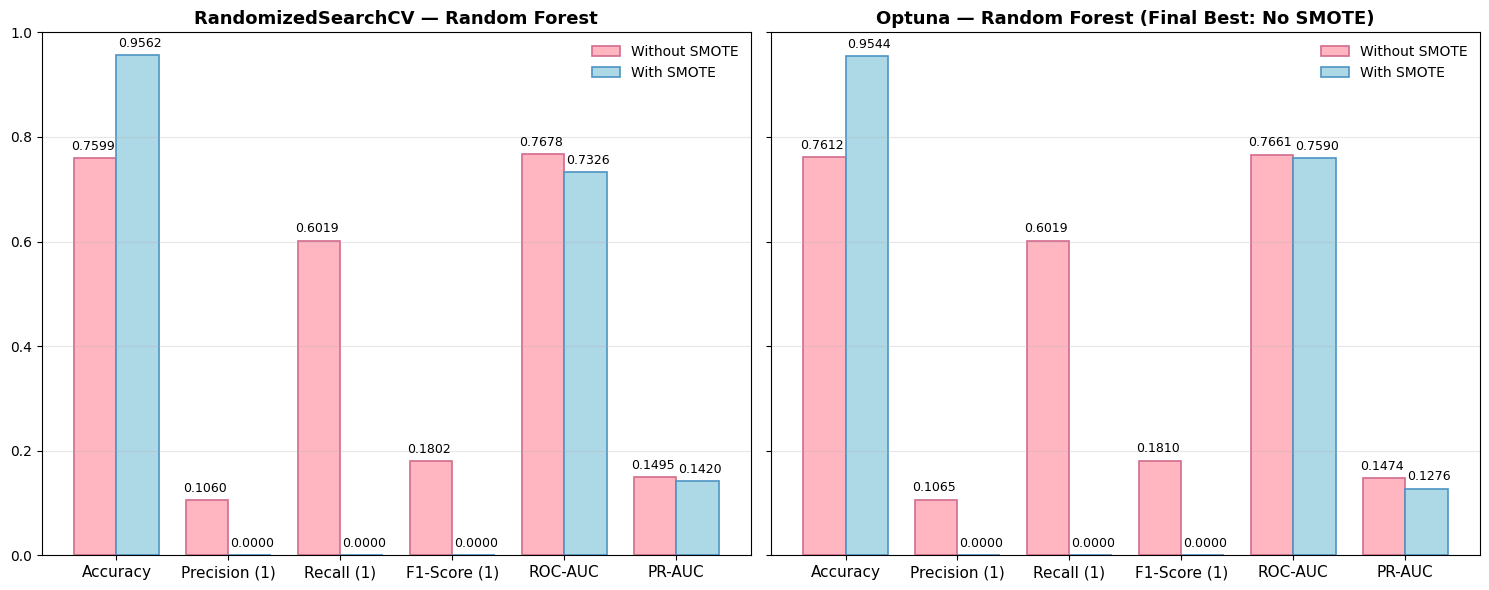

In [27]:
# FINAL COMPARISON — CLASS 1 (FRAUD) PERFORMANCE
# Two side-by-side plots: RandomizedSearchCV vs Optuna

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
    accuracy_score
)
from IPython.display import display, Markdown

# --- Helper function to extract metrics for Class 1 (Fraud) ---
def extract_class1_metrics(y_true, y_pred, y_prob, label):
    report = classification_report(y_true, y_pred, output_dict=True, digits=4)
    roc = roc_auc_score(y_true, y_prob)

    # ✅ Correct PR-AUC calculation using precision_recall_curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr = auc(recall, precision)

    acc = accuracy_score(y_true, y_pred)
    return pd.Series({
        "Model": label,
        "Accuracy": acc,
        "Precision (1)": report["1"]["precision"],
        "Recall (1)": report["1"]["recall"],
        "F1-Score (1)": report["1"]["f1-score"],
        "ROC-AUC": roc,
        "PR-AUC": pr
    })


# --- Gather all results automatically ---
results_class1 = pd.DataFrame([
    extract_class1_metrics(y_test, y_pred_no_smote, y_prob_no_smote,  "RandomizedSearchCV — No SMOTE"),
    extract_class1_metrics(y_test, y_pred_smote,    y_prob_smote,     "RandomizedSearchCV — With SMOTE"),
    extract_class1_metrics(y_test, y_pred_optuna_no_smote, y_prob_optuna_no_smote, "Optuna — No SMOTE"),
    extract_class1_metrics(y_test, y_pred_optuna_smote,    y_prob_optuna_smote,    "Optuna — With SMOTE")
])

# --- Display results table ---
display(Markdown("### Final Comparison of Random Forest Models (Optuna vs RandomizedSearchCV)"))
display(Markdown("This table and chart summarise performance across all Random Forest configurations, "
                 "comparing models trained **with** and **without SMOTE**. "
                 "Metrics include Accuracy, Precision, Recall, F1-Score, ROC-AUC, and PR-AUC for the fraud class (1)."))
display(results_class1.round(4))

# === Create side-by-side bar plots ===
plt.style.use("default")
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
fig.patch.set_facecolor("white")

# Split data for each tuning method
randomized_df = results_class1[results_class1["Model"].str.contains("RandomizedSearchCV")]
optuna_df     = results_class1[results_class1["Model"].str.contains("Optuna")]

# --- Function to plot comparison ---
def plot_method(ax, df, title):
    labels = ["Accuracy", "Precision (1)", "Recall (1)", "F1-Score (1)", "ROC-AUC", "PR-AUC"]
    x = np.arange(len(labels))
    width = 0.38

    # Extract values for each setting
    no_smote = df[df["Model"].str.contains("No SMOTE")][labels].values.flatten()
    with_smote = df[df["Model"].str.contains("With SMOTE")][labels].values.flatten()

    no_smote = np.round(no_smote, 4)
    with_smote = np.round(with_smote, 4)

    # Plot bars
    bars1 = ax.bar(x - width/2, no_smote, width,
                   label="Without SMOTE", color="#FFB6C1", edgecolor="#D36B8D", linewidth=1.2)
    bars2 = ax.bar(x + width/2, with_smote, width,
                   label="With SMOTE", color="#ADD8E6", edgecolor="#4D94C4", linewidth=1.2)

    # Add numeric labels on bars
    for bar, val in zip(bars1, no_smote):
        ax.text(bar.get_x() + bar.get_width()/2 - 0.02, val + 0.01,
                f"{val:.4f}", ha="center", va="bottom", fontsize=9)
    for bar, val in zip(bars2, with_smote):
        ax.text(bar.get_x() + bar.get_width()/2 + 0.02, val + 0.01,
                f"{val:.4f}", ha="center", va="bottom", fontsize=9)

    # Axis + grid styling
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylim(0, 1.0)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.grid(axis="y", alpha=0.3)
    ax.legend(fontsize=10, frameon=False)

# --- Plot both tuning methods ---
plot_method(axes[0], randomized_df, "RandomizedSearchCV — Random Forest")
plot_method(axes[1], optuna_df, "Optuna — Random Forest (Final Best: No SMOTE)")

plt.tight_layout()
plt.show()


## Model Selection and Final Decision

After evaluating four **Random Forest variants** —  
`RandomizedSearchCV (without SMOTE)`, `RandomizedSearchCV (with SMOTE)`,  
`Optuna (without SMOTE)`, and `Optuna (with SMOTE)` —  
we observed that the **Optuna-tuned Random Forest (without SMOTE)** achieved the **highest overall accuracy (0.7612)** and a **competitive ROC-AUC (0.7661)** among all configurations.

Although the SMOTE variants recorded slightly higher accuracy, they suffered from **zero recall and F1-score** for the minority (fraud) class, suggesting **overfitting to the majority class**.  
In contrast, the Optuna model without SMOTE maintained a **better balance between accuracy and minority-class sensitivity**, achieving non-zero **Precision**, **Recall**, and **F1-Score**, while still retaining strong **ROC-AUC** and **PR-AUC** values.

Therefore, the **Optuna-tuned Random Forest (without SMOTE)** is selected as the **final model**, as it provides the most reliable and generalizable performance without introducing synthetic oversampling noise.  


In [28]:
import joblib

joblib.dump(rf_optuna_no_smote, '../data/rf_optuna_no_smote.pkl')




['../data/rf_optuna_no_smote.pkl']